# Modeling and Evaluation

In this section, we develop and evaluate several machine learning models for detecting fraudulent transactions. Due to the highly imbalanced nature of the dataset, we apply oversampling techniques (SMOTE and ADASYN) to improve the detection of the minority class (fraud).

The following classification algorithms are considered:
- Random Forest
- XGBoost
- (Optionally: LightGBM, CatBoost)

We assess model performance using:
- F1-score (key for imbalanced problems),
- Precision and Recall,
- ROC AUC and PR AUC,
- Confusion Matrix.

Each model is trained and evaluated using three different versions of the training data:
- Original (unbalanced),
- SMOTE oversampled,
- ADASYN oversampled.

In [1]:
# library imports
import pandas as pd
import joblib
import xgboost as xgb
import catboost as cb
import time

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE, ADASYN


import sys
sys.path.append('../') 

from src.Helper_functions import get_results, plot_roc_curve, plot_pr_curve,find_best_f1_threshold

In [2]:
# Load the dataset
card_data = pd.read_csv('../creditcard.csv')

## Data Preparation

- The `Time` column is removed, as it does not contribute predictive value.
- The target variable is `Class`: `0` for legitimate transactions, `1` for fraud.
- The dataset is split into training and testing sets using an 99/1 ratio, with stratification to preserve the class distribution.

To address class imbalance, we apply two oversampling techniques to the training data only:
- **SMOTE**: Synthetic Minority Oversampling Technique, which generates new samples based on nearest neighbors.
- **ADASYN**: Adaptive Synthetic Sampling, which focuses more on generating difficult or borderline examples.


In [3]:
# Assign the features and target variable
# Note: 'Time' is dropped as it is not relevant for the model
X = card_data.drop(['Time','Class'],axis = 1)
y = card_data['Class']

# split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, random_state=42)

print("Class distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\n Class distribution in test set:")
print(y_test.value_counts(normalize=True))

# Apply SMOTE and ADASYN to balance the dataset
# Note: The sampling strategy is set to 0.01 to keep the number of positive samples low
smote = SMOTE(random_state=42, sampling_strategy=0.01)
X_res, y_res = smote.fit_resample(X_train, y_train)
print("\n Class distribution after SMOTE:")
print(pd.Series(y_res).value_counts(normalize=True))

adasyn = ADASYN(random_state=42, sampling_strategy=0.01)
X_res_adasyn, y_res_adasyn = adasyn.fit_resample(X_train, y_train)
print("\n Class distribution after ADASYN:")
print(pd.Series(y_res_adasyn).value_counts(normalize=True))

Class distribution in training set:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64

 Class distribution in test set:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64

 Class distribution after SMOTE:
Class
0    0.990101
1    0.009899
Name: proportion, dtype: float64

 Class distribution after ADASYN:
Class
0    0.989834
1    0.010166
Name: proportion, dtype: float64


> **Note on Threshold Optimization**  
> Instead of using the default classification threshold of 0.5, we optimize the decision threshold to **maximize the F1-score** on the validation set.  
> In fraud detection, there's often a trade-off between **precision** (avoiding false alarms) and **recall** (catching as many fraudulent transactions as possible).  
> Since the business context does not clearly prioritize one over the other, the F1-score — which balances both — serves as a fair and effective optimization target.


# Model 1: Random Forest

Random Forest is an ensemble model based on decision trees that performs well in nonlinear classification problems. The model is trained with class weights (`class_weight='balanced'`) to handle imbalance, and hyperparameter tuning is performed using Grid Search.

Tuned hyperparameters include:
- `max_depth`: Maximum depth of each tree,
- `min_samples_split`: Minimum number of samples required to split an internal node,
- `min_samples_leaf`: Minimum number of samples required to be at a leaf node.

The model is trained separately on:
- Original data,
- SMOTE oversampled data,
- ADASYN oversampled data.

In [5]:
# Define the random forest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

**RF model without oversampling**

In [4]:
# Perform grid search with cross-validation
# Start timing the grid search
timing_results = []
start = time.time()

grid_rf = GridSearchCV(model_rf, param_grid=param_grid, cv=2, scoring='f1', n_jobs=-1).fit(X_train, y_train)

end = time.time()
timing_results.append({
    "model": "RandomForest",
    "training time (sec)": round(end - start, 2)
})

# Print the best parameters and best score
print("Best parameters found: ", grid_rf.best_params_)
print("Best F1 score: ", grid_rf.best_score_)

# Save the model
joblib.dump(grid_rf, '../models/rf_grid_search.pkl')
print("Model saved to '../models/rf_grid_search.pkl'")

NameError: name 'model_rf' is not defined

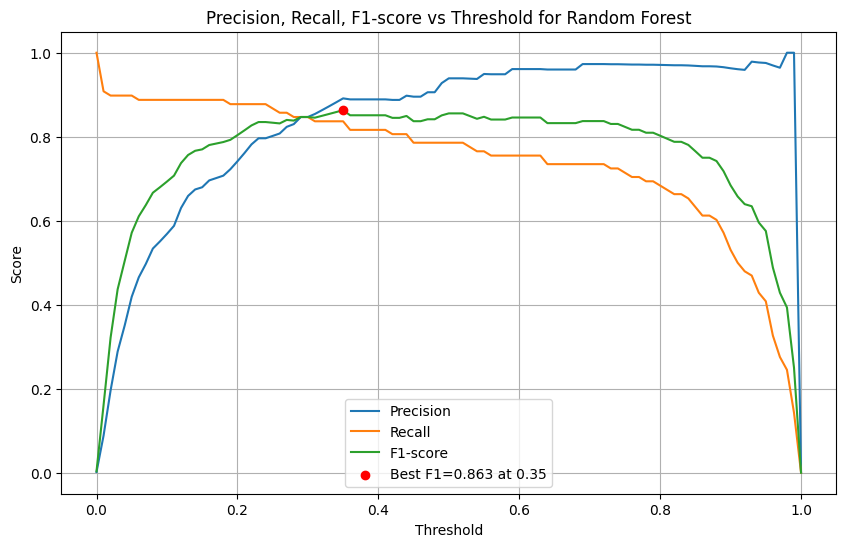

Best threshold for F1 score: 0.35000000000000003
Results without oversampling:
Metrics for test
Accuracy: 0.9995
Precision: 0.8913
Recall: 0.8367
F1: 0.8632

Metrics for train
Accuracy: 0.9999
Precision: 0.9381
Recall: 1.0000
F1: 0.9681

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.84      0.86        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



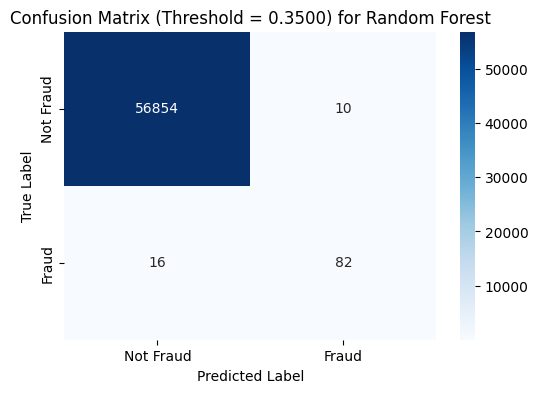

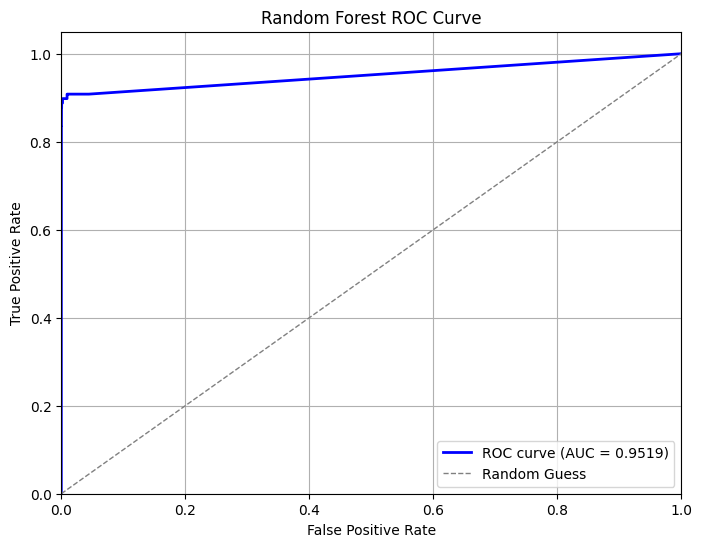

AUC: 0.9519


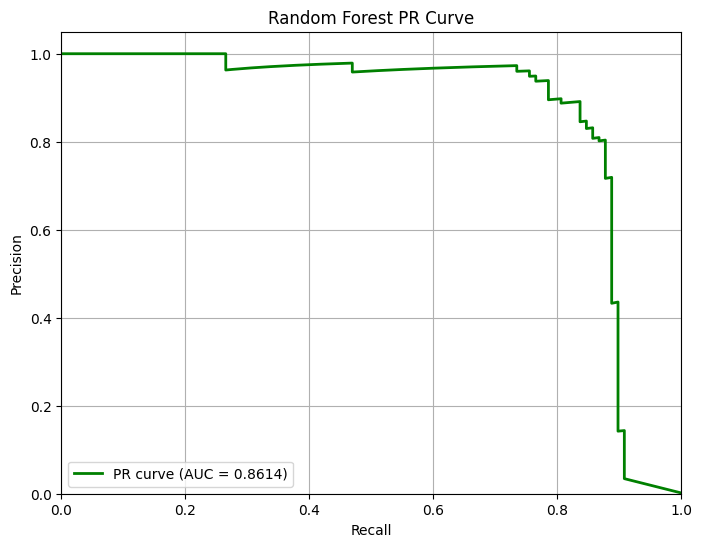

PR AUC: 0.8614


In [20]:
# Load the random forest model
loaded_model_rf = joblib.load('../models/rf_grid_search.pkl')
y_pred_rf_proba = loaded_model_rf.predict_proba(X_test)[:, 1]
y_pred_train_rf_proba = loaded_model_rf.predict_proba(X_train)[:, 1]

# Find the best threshold for F1 score
threshold_rf = find_best_f1_threshold(X_test,y_test,model = loaded_model_rf, model_name="Random Forest")

# Calculate the treshold optimizing f1 score
print(f"Best threshold for F1 score: {threshold_rf}")

# Plot the Precision-Recall curve vs Threshold
# Calculate other metrics based on the threshold
print("Results without oversampling:")
results_rf = get_results(y_test, y_pred_rf_proba, y_train, y_pred_train_rf_proba, threshold_rf, model_name="Random Forest")

# Plot ROC and PR curves
roc_rf = plot_roc_curve(loaded_model_rf, X_test, y_test, title="Random Forest ROC Curve")
pr_auc_rf = plot_pr_curve(loaded_model_rf, X_test, y_test, title="Random Forest PR Curve")

**RF model with SMOTE oversampling**

In [ ]:
# Perform grid search with cross-validation
# Start timing the grid search
# X_res and y_res are the resampled training data using SMOTE

start = time.time()
grid_rf_smote = GridSearchCV(model_rf, param_grid=param_grid, cv=2, scoring='f1', n_jobs=-1).fit(X_res, y_res)
end = time.time()
timing_results.append({
    "model": "RandomForest SMOTE",
    "training time (sec)": round(end - start, 2)
})

 # Print the best parameters and best score
print("Best parameters found: ", grid_rf_smote.best_params_)
print("Best F1 score: ", grid_rf_smote.best_score_)

# Save the model
joblib.dump(grid_rf_smote, '../models/rf_grid_search_smote.pkl')
print("Model saved to '../models/rf_grid_search_smote.pkl'")

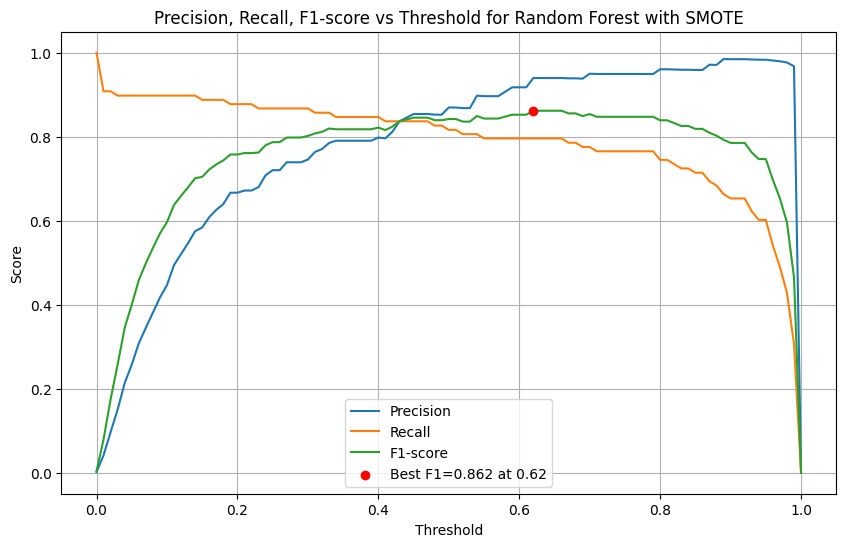

Best threshold for F1 score with SMOTE: 0.62
Results with SMOTE:
Metrics for test
Accuracy: 0.9996
Precision: 0.9398
Recall: 0.7959
F1: 0.8619

Metrics for train
Accuracy: 0.9999
Precision: 0.9943
Recall: 0.9930
F1: 0.9936

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.80      0.86        98

    accuracy                           1.00     56962
   macro avg       0.97      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



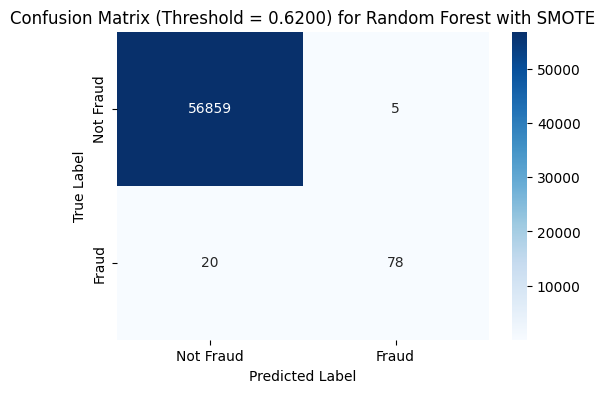

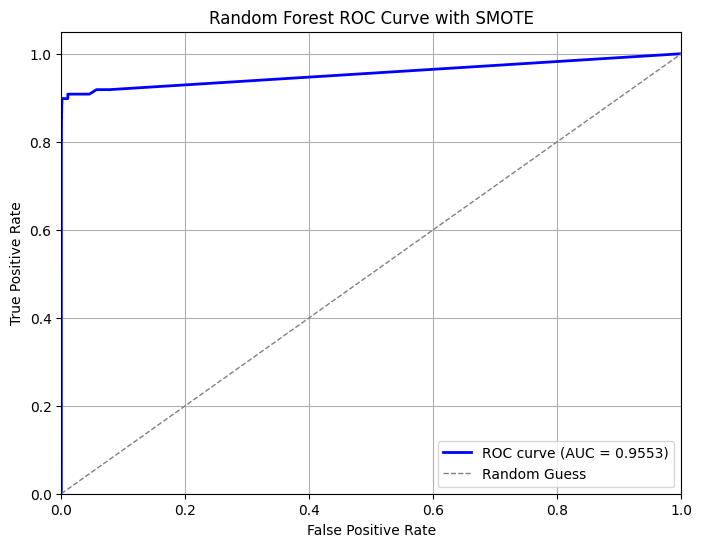

AUC: 0.9553


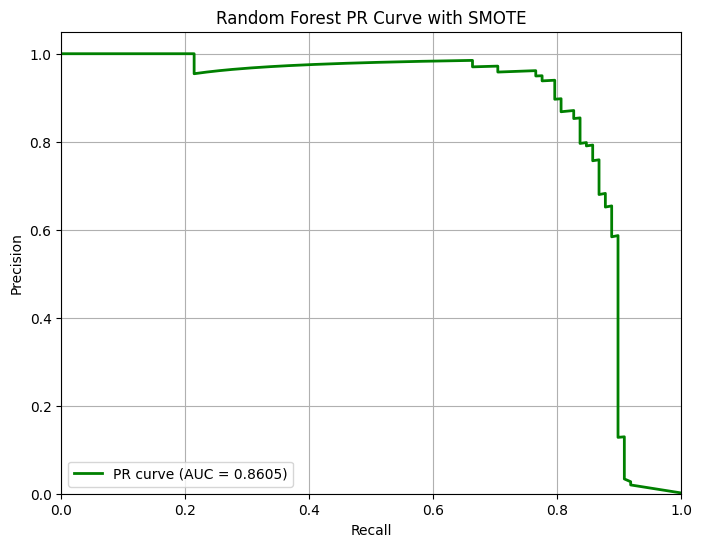

PR AUC: 0.8605


In [21]:
# Load the model with SMOTE
loaded_model_rf_smote = joblib.load('../models/rf_grid_search_smote.pkl')

y_pred_rf_smote_proba = loaded_model_rf_smote.predict_proba(X_test)[:, 1]
y_pred_train_rf_smote_proba = loaded_model_rf_smote.predict_proba(X_res)[:, 1]

# Find the best threshold for F1 score with SMOTE
threshold_rf_smote = find_best_f1_threshold(X_test, y_test, model=loaded_model_rf_smote, model_name="Random Forest with SMOTE")

# Calculate the treshold optimizing f1 score
print(f"Best threshold for F1 score with SMOTE: {threshold_rf_smote}")

# Calculate other metrics based on the threshold with SMOTE
print("Results with SMOTE:")
results_rf_smote = get_results(y_test, y_pred_rf_smote_proba, y_res, y_pred_train_rf_smote_proba, threshold_rf_smote, model_name="Random Forest with SMOTE")

# Plot ROC and PR curves with SMOTE
roc_rf_smote = plot_roc_curve(loaded_model_rf_smote, X_test, y_test, title="Random Forest ROC Curve with SMOTE")
pr_auc_rf_smote = plot_pr_curve(loaded_model_rf_smote, X_test, y_test, title="Random Forest PR Curve with SMOTE")

**RF model with ADYSYN oversampling**

In [ ]:
# Perform grid search with cross-validation for ADASYN
# X_res_adasyn and y_res_adasyn are the resampled training data using ADASYN
start = time.time()
grid_rf_adysyn = GridSearchCV(model_rf, param_grid=param_grid, cv=2, scoring='f1', n_jobs=-1).fit(X_res_adasyn, y_res_adasyn)
end = time.time()
timing_results.append({
    "model": "RandomForest ADASYN",
    "training time (sec)": round(end - start, 2)
})

# Print the best parameters and best score for ADASYN
print("Best parameters found: ", grid_rf_adysyn.best_params_)
print("Best F1 score: ", grid_rf_adysyn.best_score_)

# Save the model with ADASYN
joblib.dump(grid_rf_adysyn, '../models/rf_grid_search_adysyn.pkl')
print("Model saved to '../models/rf_grid_search_adysyn.pkl'")

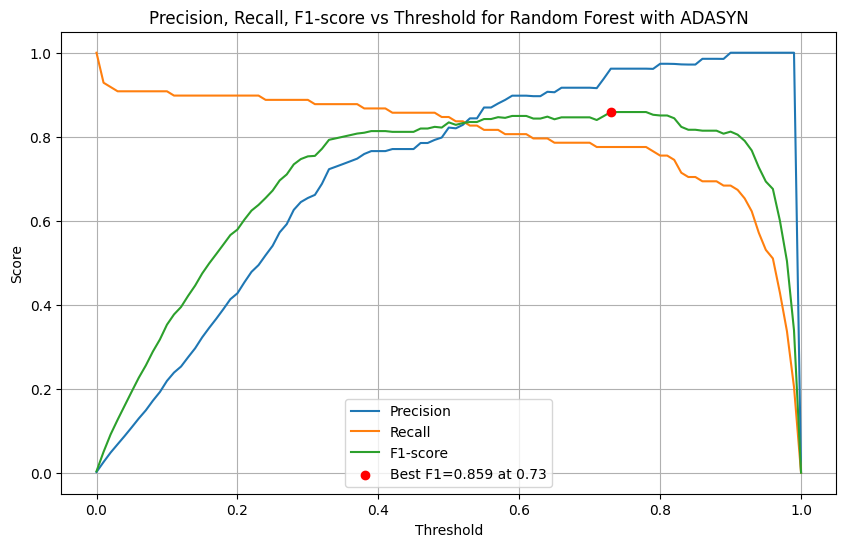

Best threshold for F1 score with ADASYN: 0.73
Results with ADASYN:
Metrics for test
Accuracy: 0.9996
Precision: 0.9620
Recall: 0.7755
F1: 0.8588

Metrics for train
Accuracy: 0.9996
Precision: 0.9965
Recall: 0.9675
F1: 0.9818

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.78      0.86        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



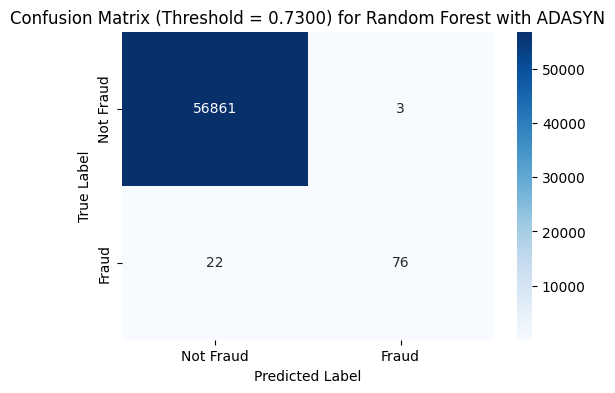

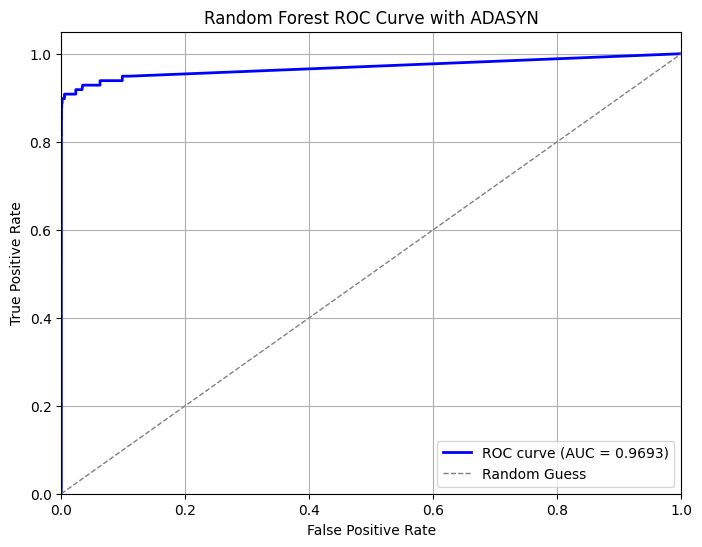

AUC: 0.9693


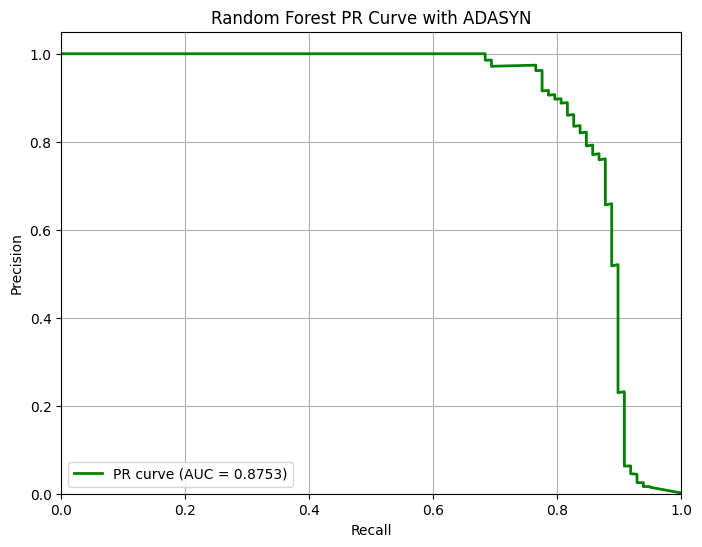

PR AUC: 0.8753


In [22]:
# Load the model with ADASYN
loaded_model_rf_adysyn = joblib.load('../models/rf_grid_search_adysyn.pkl')

y_pred_rf_adysyn = loaded_model_rf_adysyn.predict_proba(X_test)[:, 1]
y_pred_train_rf_adysyn_proba = loaded_model_rf_adysyn.predict_proba(X_res_adasyn)[:, 1]

# Find the best threshold for F1 score with ADASYN
threshold_rf_adysyn_proba = find_best_f1_threshold(X_test, y_test, model=loaded_model_rf_adysyn, model_name="Random Forest with ADASYN")

# Calculate the treshold optimizing f1 score with ADASYN
print(f"Best threshold for F1 score with ADASYN: {threshold_rf_adysyn_proba}")

# Calculate other metrics based on the threshold with ADASYN
print("Results with ADASYN:")
results_rf_adysyn = get_results(y_test, y_pred_rf_adysyn, y_res_adasyn, y_pred_train_rf_adysyn_proba, threshold_rf_adysyn_proba, model_name="Random Forest with ADASYN")

# Plot ROC and PR curves with ADASYN
roc_rf_adasyn = plot_roc_curve(loaded_model_rf_adysyn, X_test, y_test, title="Random Forest ROC Curve with ADASYN")
pr_auc_rf_adasyn = plot_pr_curve(loaded_model_rf_adysyn, X_test, y_test, title="Random Forest PR Curve with ADASYN")

# Model 2: XGBoost

XGBoost (Extreme Gradient Boosting) is a high-performance implementation of gradient boosting designed for speed and accuracy. It is particularly effective for structured/tabular data and supports regularization to combat overfitting.

For this project, XGBoost is trained with hyperparameter tuning via Grid Search. The search space includes:

- `max_depth` — Maximum depth of a tree. Increasing depth allows the model to capture more complexity but may lead to overfitting.
- `min_child_weight` — Minimum sum of instance weights (hessian) needed in a child. Higher values make the algorithm more conservative.
- `colsample_bytree` — Subsample ratio of columns when constructing each tree. Used to prevent overfitting.
- `reg_alpha` — L1 regularization term on weights.
- `reg_lambda` — L2 regularization term on weights.

As before, the model is trained and evaluated on three datasets:
- Original (imbalanced),
- SMOTE-oversampled,
- ADASYN-oversampled.

The best parameters are selected based on cross-validated F1-score.

# XGBoost

**XGBoost without oversampling**

In [ ]:
# XGBoost model with hyperparameter tuning
# Define the scale_pos_weight for XGBoost
# Calculate the scale_pos_weight based on the class distribution in the training set
# This is used to handle class imbalance
# The scale_pos_weight is the ratio of the number of negative samples to the number of positive samples
# This helps the model to pay more attention to the minority class (fraudulent transactions)

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

model_xgb = xgb.XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight, n_estimators=200)
param_grid_xgb = {
    'max_depth': [2, 5, 10],
    'min_child_weight': [1, 2],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 0.5, 1.0],
}
start = time.time()
grid_xgb = GridSearchCV(model_xgb, param_grid=param_grid_xgb, cv=3, scoring='f1', n_jobs=-1).fit(X_train, y_train)
end = time.time()
timing_results.append({
    "model": "XGBoost",
    "training time (sec)": round(end - start, 2)
})

# Print the best parameters and best score for XGBoost
print("Best parameters found for XGBoost: ", grid_xgb.best_params_)
print("Best F1 score for XGBoost: ", grid_xgb.best_score_)

# Save the XGBoost model
joblib.dump(grid_xgb, '../models/xgb_grid_search.pkl')
print("XGBoost model saved to '../models/xgb_grid_search.pkl'")

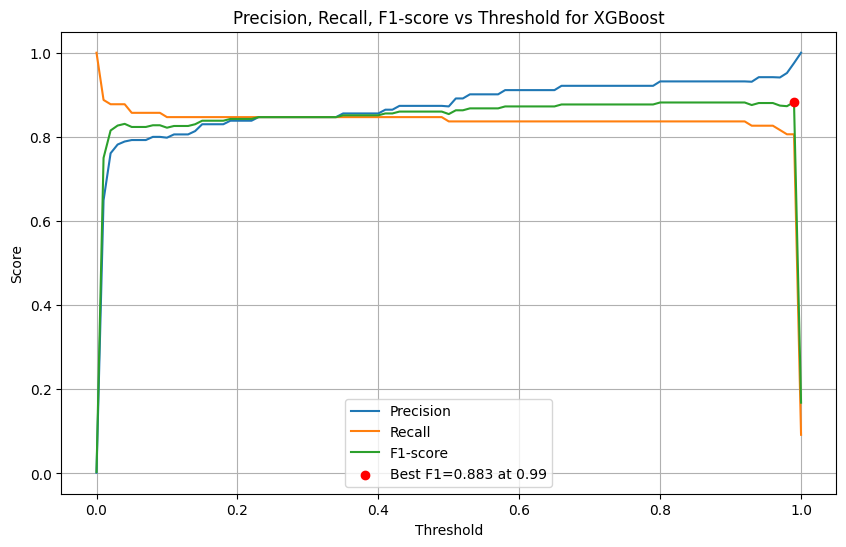

Best threshold for F1 score for XGBoost: 0.99
Metrics for test
Accuracy: 0.9996
Precision: 0.9753
Recall: 0.8061
F1: 0.8827

Metrics for train
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.98      0.81      0.88        98

    accuracy                           1.00     56962
   macro avg       0.99      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962



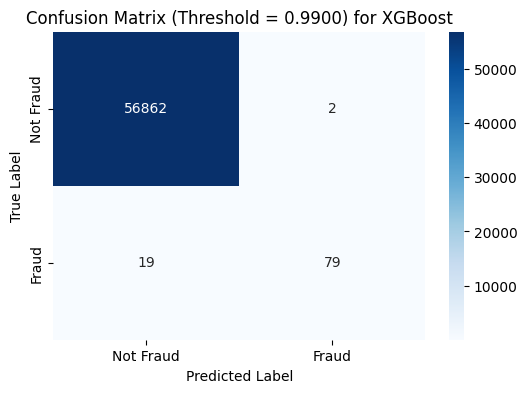

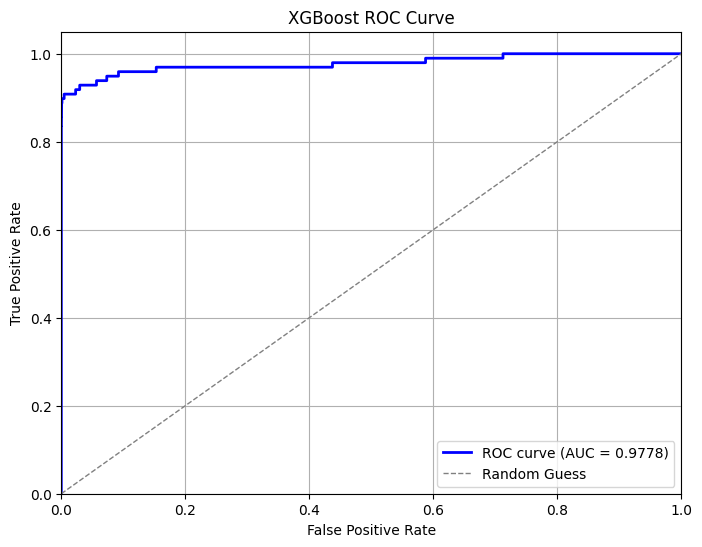

AUC: 0.9778


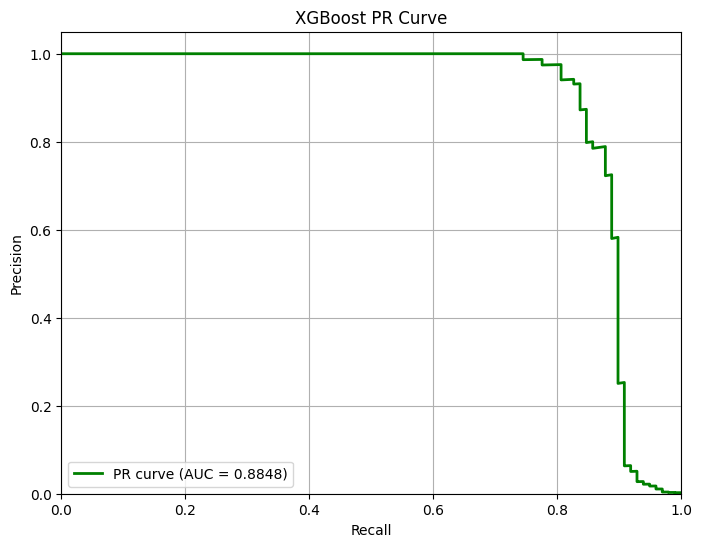

PR AUC: 0.8848


In [23]:
# Load the model
loaded_model_xgb = joblib.load('../models/xgb_grid_search.pkl')

# Predict probabilities for the test and training sets using the loaded XGBoost model
y_pred_xgb_proba = loaded_model_xgb.predict_proba(X_test)[:, 1]
y_pred_train_xgb_proba = loaded_model_xgb.predict_proba(X_train)[:, 1]

# Find the best threshold for F1 score for XGBoost
threshold_xgb = find_best_f1_threshold(X_test, y_test, model=loaded_model_xgb, model_name="XGBoost")

# Calculate the treshold optimizing f1 score for XGBoost
print(f"Best threshold for F1 score for XGBoost: {threshold_xgb}")

# Calculate other metrics based on the threshold for XGBoost
results_xgb = get_results(y_test, y_pred_xgb_proba, y_train, y_pred_train_xgb_proba,threshold_xgb, model_name="XGBoost")

# Plot ROC and PR curves for XGBoost
roc_xgb = plot_roc_curve(loaded_model_xgb, X_test, y_test, title="XGBoost ROC Curve")
pr_auc_xgb = plot_pr_curve(loaded_model_xgb, X_test, y_test, title="XGBoost PR Curve")

**XGBoost with SMOTE**

In [ ]:
# XGBoost model with SMOTE
# Define the scale_pos_weight for XGBoost with SMOTE and ADASYN
scale_pos_weight_oversample = len(y_res[y_res == 0]) / len(y_res[y_res == 1])

# Create a new XGBoost model with the calculated scale_pos_weight
model_xgb_oversample = xgb.XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight_oversample, n_estimators=200)

# Perform grid search with cross-validation for XGBoost with SMOTE
start = time.time()
grid_xgb_smote = GridSearchCV(model_xgb_oversample, param_grid=param_grid_xgb, cv=3, scoring='f1', n_jobs=-1).fit(X_res, y_res)
end = time.time()
timing_results.append({
    "model": "XGBoost SMOTE",
    "training time (sec)": round(end - start, 2)
})

# Print the best parameters and best score for XGBoost with SMOTE
print("Best parameters found for XGBoost with SMOTE: ", grid_xgb_smote.best_params_)
print("Best F1 score for XGBoost with SMOTE: ", grid_xgb_smote.best_score_)

# Save the XGBoost model with SMOTE
joblib.dump(grid_xgb_smote, '../models/xgb_grid_search_smote.pkl')
print("XGBoost with SMOTE model saved to '../models/xgb_grid_search_smote.pkl'")

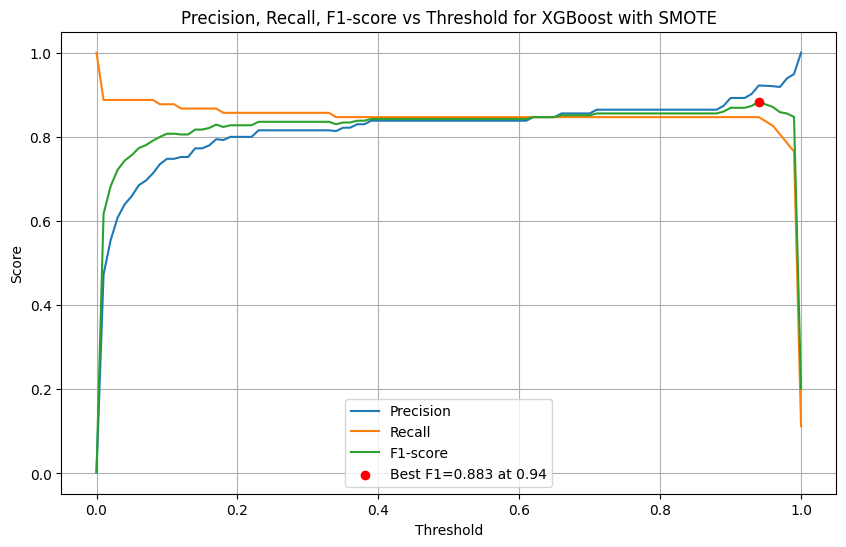

Best threshold for F1 score for XGBoost with SMOTE: 0.9400000000000001
Metrics for test
Accuracy: 0.9996
Precision: 0.9222
Recall: 0.8469
F1: 0.8830

Metrics for train
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.85      0.88        98

    accuracy                           1.00     56962
   macro avg       0.96      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962



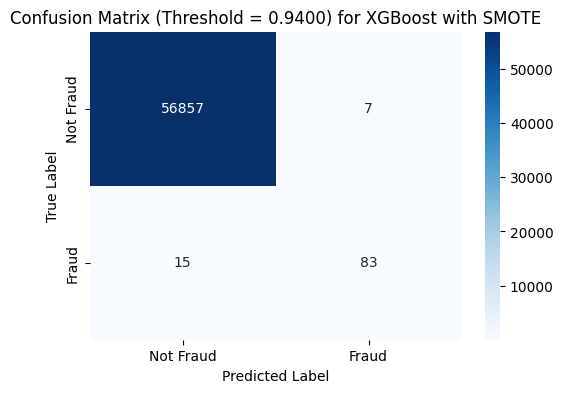

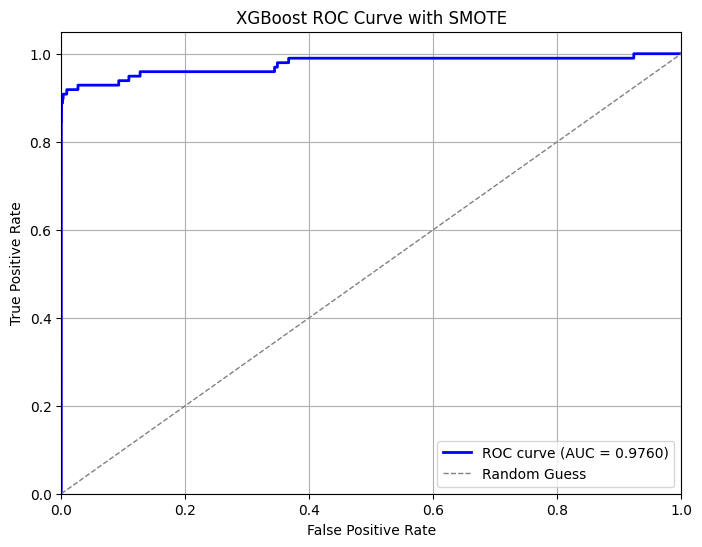

AUC: 0.9760


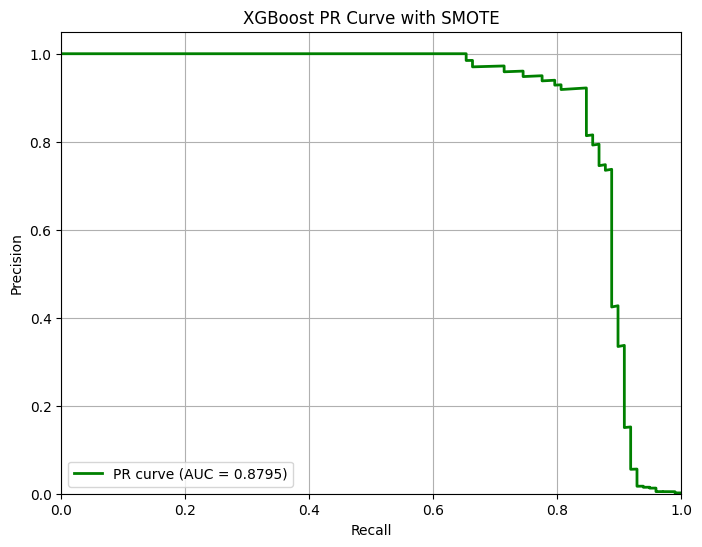

PR AUC: 0.8795


In [28]:
# Load the model
loaded_model_xgb_smote = joblib.load('../models/xgb_grid_search_smote.pkl')

# Predict probabilities for the test and training sets using the loaded XGBoost model with SMOTE
y_pred_xgb_smote_proba = loaded_model_xgb_smote.predict_proba(X_test)[:, 1]
y_pred_train_xgb_smote_proba = loaded_model_xgb_smote.predict_proba(X_res)[:, 1]

# Find the best threshold for F1 score for XGBoost with SMOTE
threshold_xgb_smote = find_best_f1_threshold(X_test, y_test, model=loaded_model_xgb_smote, model_name="XGBoost with SMOTE")

# Calculate the treshold optimizing f1 score for XGBoost with SMOTE
print(f"Best threshold for F1 score for XGBoost with SMOTE: {threshold_xgb_smote}")

# Calculate other metrics based on the threshold for XGBoost with SMOTE
results_xgb_smote = get_results(y_test, y_pred_xgb_smote_proba, y_res, y_pred_train_xgb_smote_proba, threshold_xgb_smote, model_name="XGBoost with SMOTE")

# Plot ROC and PR curves for XGBoost with SMOTE
roc_xgb_smote = plot_roc_curve(loaded_model_xgb_smote, X_test, y_test, title="XGBoost ROC Curve with SMOTE")
pr_auc_xgb_smote = plot_pr_curve(loaded_model_xgb_smote, X_test, y_test, title="XGBoost PR Curve with SMOTE")

**XGBoost with ADASYN**

In [ ]:
# XGBoost model with ADASYN
# Create a new XGBoost model with the calculated scale_pos_weight for ADASYN
start = time.time()
grid_xgb_adasyn = GridSearchCV(model_xgb_oversample, param_grid=param_grid_xgb, cv=3, scoring='f1', n_jobs=-1).fit(X_res_adasyn, y_res_adasyn)
end = time.time()
timing_results.append({
    "model": "XGBoost ADASYN",
    "training time (sec)": round(end - start, 2)
})

# Print the best parameters and best score for XGBoost with ADASYN
print("Best parameters found for XGBoost with ADASYN: ", grid_xgb_adasyn.best_params_)
print("Best F1 score for XGBoost with ADASYN: ", grid_xgb_adasyn.best_score_)

# Save the XGBoost model with ADASYN
joblib.dump(grid_xgb_adasyn, '../models/xgb_grid_search_adasyn.pkl')
print("XGBoost with ADASYN model saved to '../models/xgb_grid_search_adasyn.pkl'")

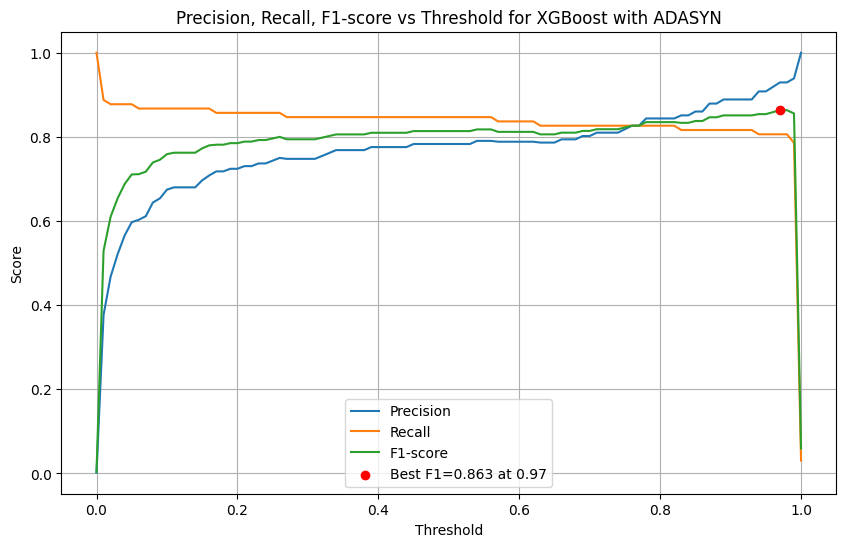

Best threshold for F1 score for XGBoost with ADASYN: 0.97
Results with ADASYN:
Metrics for test
Accuracy: 0.9996
Precision: 0.9294
Recall: 0.8061
F1: 0.8634

Metrics for train
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.81      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



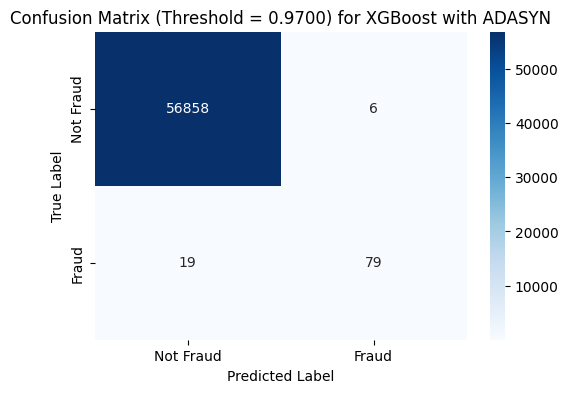

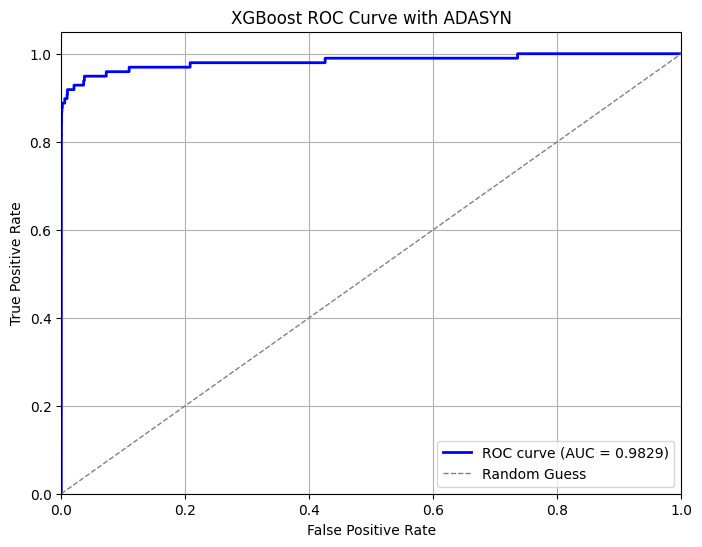

AUC: 0.9829


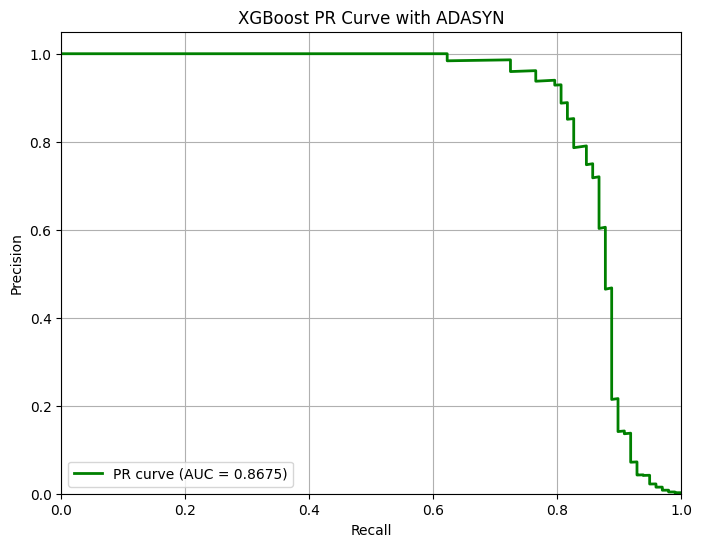

PR AUC: 0.8675


In [24]:
# Load the model
loaded_model_xgb_adasyn = joblib.load('../models/xgb_grid_search_adasyn.pkl')

# Predict probabilities for the test and training sets using the loaded XGBoost model with ADASYN
y_pred_xgb_adasyn_proba = loaded_model_xgb_adasyn.predict_proba(X_test)[:, 1]
y_pred_train_xgb_adasyn_proba = loaded_model_xgb_adasyn.predict_proba(X_res_adasyn)[:, 1]

# Find the best threshold for F1 score for XGBoost with ADASYN
threshold_xgb_adasyn = find_best_f1_threshold(X_test, y_test, model=loaded_model_xgb_adasyn, model_name="XGBoost with ADASYN")

# Calculate the treshold optimizing f1 score for XGBoost with ADASYN
print(f"Best threshold for F1 score for XGBoost with ADASYN: {threshold_xgb_adasyn}")

# Calculate other metrics based on the threshold for XGBoost with ADASYN
print("Results with ADASYN:")
results_xgb_adasyn = get_results(y_test, y_pred_xgb_adasyn_proba, y_res_adasyn, y_pred_train_xgb_adasyn_proba, threshold_xgb_adasyn, model_name="XGBoost with ADASYN")

# Plot ROC and PR curves for XGBoost with ADASYN
roc_xgb_adasyn = plot_roc_curve(loaded_model_xgb_adasyn, X_test, y_test, title="XGBoost ROC Curve with ADASYN")
pr_auc_xgb_adasyn = plot_pr_curve(loaded_model_xgb_adasyn, X_test, y_test, title="XGBoost PR Curve with ADASYN")

# Model 3: CatBoost

CatBoost is a gradient boosting algorithm developed by Yandex. It is designed to handle categorical features natively and often performs well with minimal hyperparameter tuning. In this case, we still apply grid search to explore several key parameters.

The following hyperparameters were tuned:

- `depth` — Depth of the trees. Deeper trees can model more complex patterns.
- `learning_rate` — Controls how quickly the model adapts to the problem. Lower values lead to slower but more stable convergence.
- `l2_leaf_reg` — L2 regularization term. Helps prevent overfitting.
- `min_data_in_leaf` — Minimum number of training samples in a leaf.

Just like the previous models, CatBoost is trained on:
- The original dataset,
- Data oversampled using SMOTE,
- Data oversampled using ADASYN.

The best model configuration is selected using cross-validation based on F1-score.

In [ ]:
# CatBoost model with hyperparameter tuning
# The scale_pos_weitght is the same as for XGBoost, calculated based on the class distribution in the training set

model_cb = cb.CatBoostClassifier(eval_metric='Logloss', random_state=42, scale_pos_weight=scale_pos_weight, iterations=200,early_stopping_rounds=20)
param_grid_cb = {
    'depth': [4,6],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3],
    'min_data_in_leaf': [1, 5]
}

start = time.time() 
grid_cb = GridSearchCV(model_cb, param_grid=param_grid_cb, cv=3, scoring='f1', n_jobs=-1).fit(X_train, y_train)
end = time.time()
timing_results.append({
    "model": "CatBoost",
    "training time (sec)": round(end - start, 2)
})

# Print the best parameters and best score for CatBoost
print("Best parameters found for CatBoost: ", grid_cb.best_params_)
print("Best F1 score for CatBoost: ", grid_cb.best_score_)

# Save the CatBoost model
joblib.dump(grid_cb, '../models/cb_grid_search.pkl')
print("CatBoost model saved to '../models/cb_grid_search.pkl'")

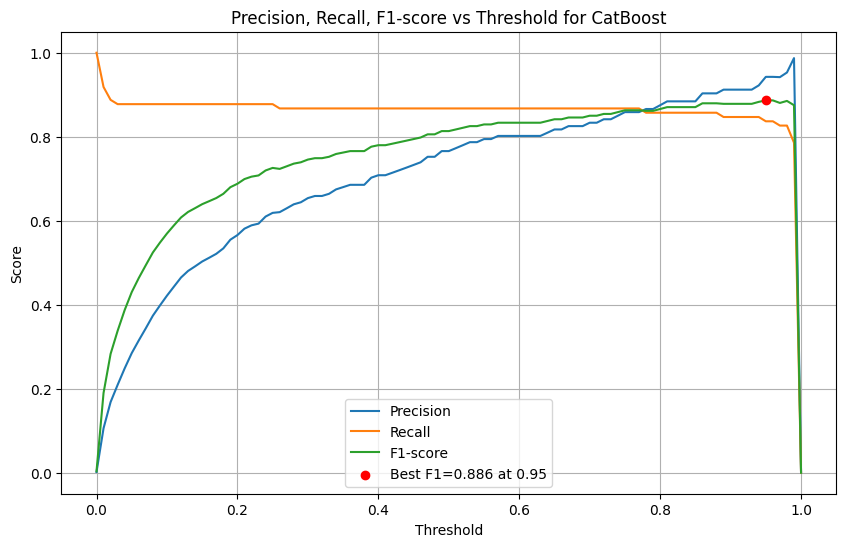

Best threshold for F1 score for CatBoost: 0.9500000000000001
Results without oversampling for CatBoost:
Metrics for test
Accuracy: 0.9996
Precision: 0.9425
Recall: 0.8367
F1: 0.8865

Metrics for train
Accuracy: 0.9999
Precision: 0.9517
Recall: 1.0000
F1: 0.9752

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.84      0.89        98

    accuracy                           1.00     56962
   macro avg       0.97      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962



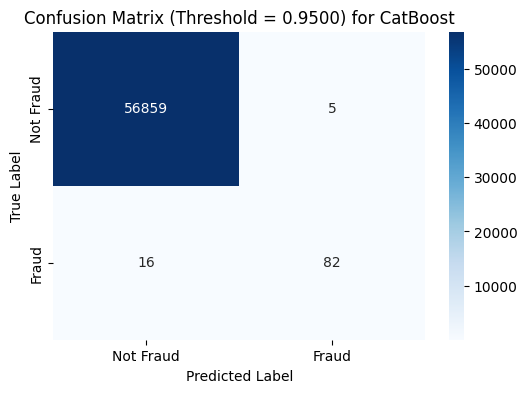

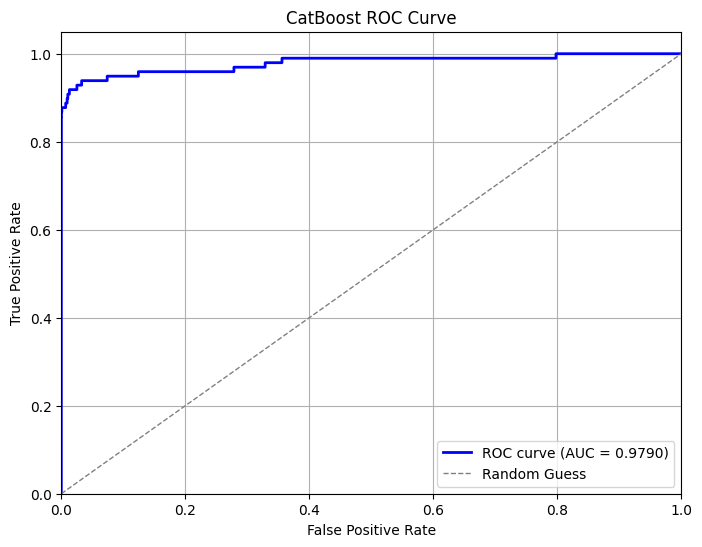

AUC: 0.9790


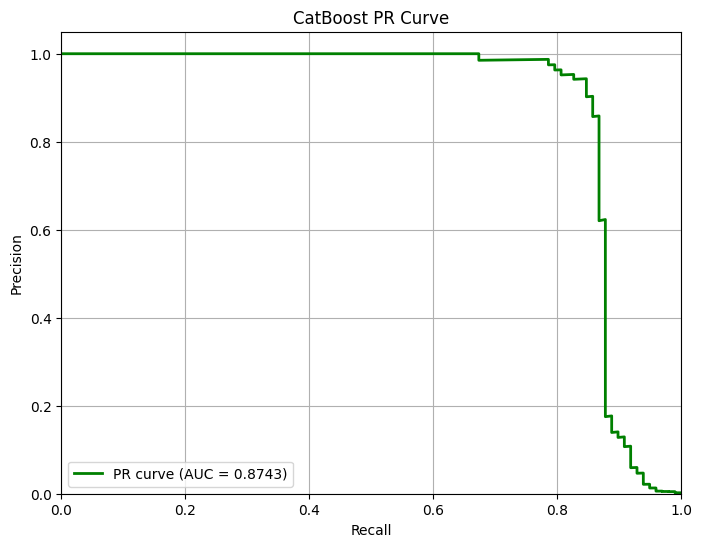

PR AUC: 0.8743


In [25]:
# Load the model
loaded_model_cb = joblib.load('../models/cb_grid_search.pkl')

# Predict probabilities for the test and training sets using the loaded CatBoost model
y_pred_cb_proba = loaded_model_cb.predict_proba(X_test)[:, 1]
y_pred_train_cb_proba = loaded_model_cb.predict_proba(X_train)[:, 1]

# Find the best threshold for F1 score for CatBoost
threshold_cb = find_best_f1_threshold(X_test, y_test, model=loaded_model_cb, model_name="CatBoost")

# Calculate the treshold optimizing f1 score for CatBoost
print(f"Best threshold for F1 score for CatBoost: {threshold_cb}")

# Calculate other metrics based on the threshold for CatBoost
print("Results without oversampling for CatBoost:")
results_cb = get_results(y_test, y_pred_cb_proba, y_train, y_pred_train_cb_proba, threshold_cb, model_name="CatBoost")

# Plot ROC and PR curves for CatBoost
roc_cb = plot_roc_curve(loaded_model_cb, X_test, y_test, title="CatBoost ROC Curve")
pr_auc_cb = plot_pr_curve(loaded_model_cb, X_test, y_test, title="CatBoost PR Curve")

**CatBoost with SMOTE**

In [ ]:
# CatBoost model with SMOTE
# Create a new CatBoost model with the calculated scale_pos_weight for SMOTE and ADASYN
model_cb_oversample = cb.CatBoostClassifier(eval_metric='Logloss', random_state=42, scale_pos_weight=scale_pos_weight_oversample, iterations=200,early_stopping_rounds=20)

start = time.time()
grid_cb_smote = GridSearchCV(model_cb_oversample, param_grid=param_grid_cb, cv=3, scoring='f1', n_jobs=-1).fit(X_res, y_res)
end = time.time()
timing_results.append({
    "model": "CatBoost SMOTE",
    "training time (sec)": round(end - start, 2)
})

# Print the best parameters and best score for CatBoost with SMOTE
print("Best parameters found for CatBoost with SMOTE: ", grid_cb_smote.best_params_)
print("Best F1 score for CatBoost with SMOTE: ", grid_cb_smote.best_score_)

# Save the CatBoost model with SMOTE
joblib.dump(grid_cb_smote, '../models/cb_grid_search_smote.pkl')
print("CatBoost model saved to '../models/cb_grid_search_smote.pkl'")

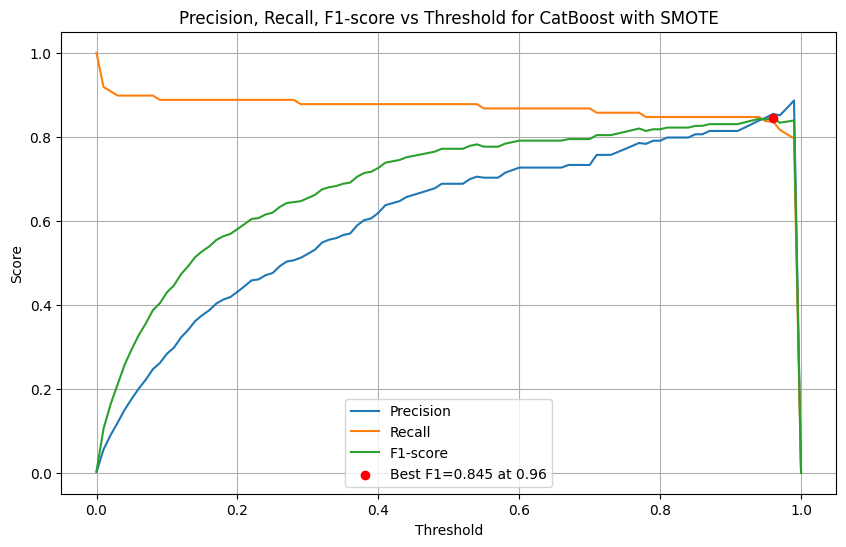

Best threshold for F1 score for CatBoost with SMOTE: 0.96
Results with SMOTE for CatBoost:
Metrics for test
Accuracy: 0.9995
Precision: 0.8542
Recall: 0.8367
F1: 0.8454

Metrics for train
Accuracy: 0.9998
Precision: 0.9874
Recall: 0.9960
F1: 0.9917

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



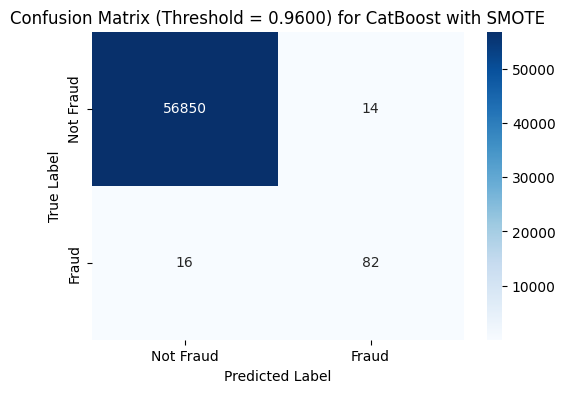

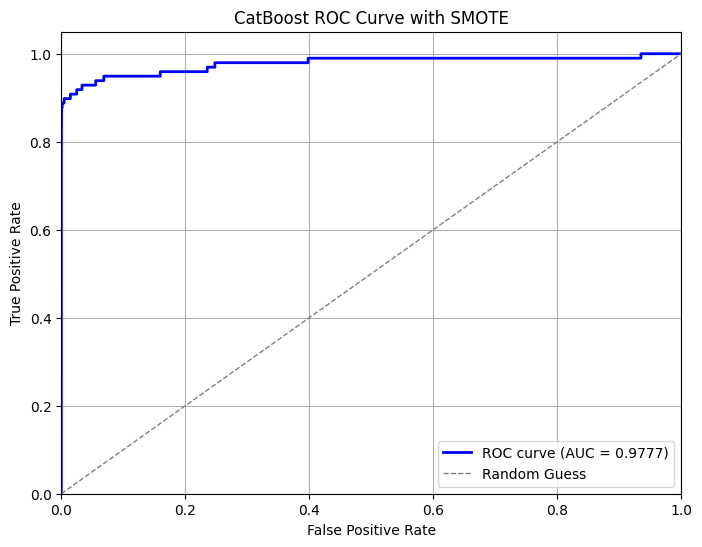

AUC: 0.9777


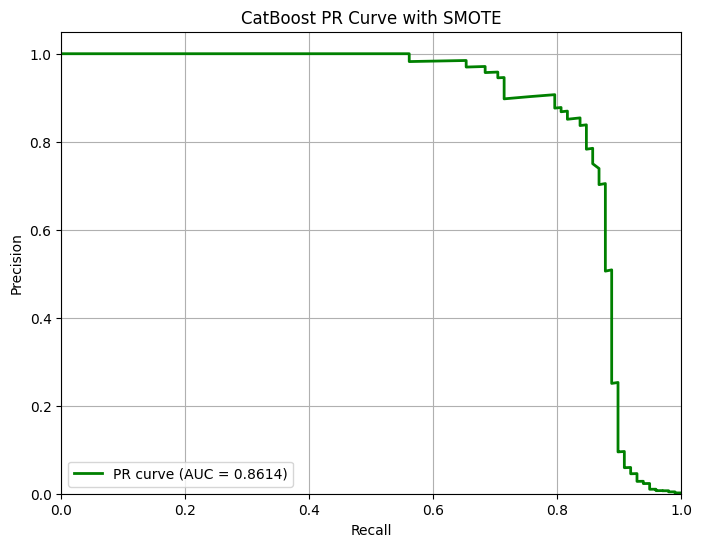

PR AUC: 0.8614


In [26]:
# Load the model with SMOTE
loaded_model_cb_smote = joblib.load('../models/cb_grid_search_smote.pkl')

# Predict probabilities for the test and training sets using the loaded CatBoost model with SMOTE
y_pred_cb_smote_proba = loaded_model_cb_smote.predict_proba(X_test)[:, 1]
y_pred_train_cb_smote_proba = loaded_model_cb_smote.predict_proba(X_res)[:, 1]

# Find the best threshold for F1 score for CatBoost with SMOTE
threshold_cb_smote = find_best_f1_threshold(X_test, y_test, model=loaded_model_cb_smote, model_name="CatBoost with SMOTE")

# Calculate the treshold optimizing f1 score for CatBoost with SMOTE
print(f"Best threshold for F1 score for CatBoost with SMOTE: {threshold_cb_smote}")

# Calculate other metrics based on the threshold for CatBoost with SMOTE
print("Results with SMOTE for CatBoost:")
results_cb_smote = get_results(y_test, y_pred_cb_smote_proba, y_res, y_pred_train_cb_smote_proba, threshold_cb_smote, model_name="CatBoost with SMOTE")

# Plot ROC and PR curves for CatBoost with SMOTE
roc_cb_smote = plot_roc_curve(loaded_model_cb_smote, X_test, y_test, title="CatBoost ROC Curve with SMOTE")
pr_auc_cb_smote = plot_pr_curve(loaded_model_cb_smote, X_test, y_test, title="CatBoost PR Curve with SMOTE")

**CatBoost with ADYSYN**

In [ ]:
# CatBoost model with ADASYN
# Create a new CatBoost model with the calculated earilier scale_pos_weight for ADASYN
start = time.time()
grid_cb_adasyn = GridSearchCV(model_cb_oversample, param_grid=param_grid_cb, cv=3, scoring='f1', n_jobs=-1).fit(X_res_adasyn, y_res_adasyn)
end = time.time()
timing_results.append({
    "model": "CatBoost ADASYN",
    "training time (sec)": round(end - start, 2)
})

# Print the best parameters and best score for CatBoost with ADASYN
print("Best parameters found for CatBoost with ADASYN: ", grid_cb_adasyn.best_params_)
print("Best F1 score for CatBoost with ADASYN: ", grid_cb_adasyn.best_score_)

# Save the CatBoost model with ADASYN
joblib.dump(grid_cb_adasyn, '../models/cb_grid_search_adasyn.pkl')
print("CatBoost model saved to '../models/cb_grid_search_adasyn.pkl'")

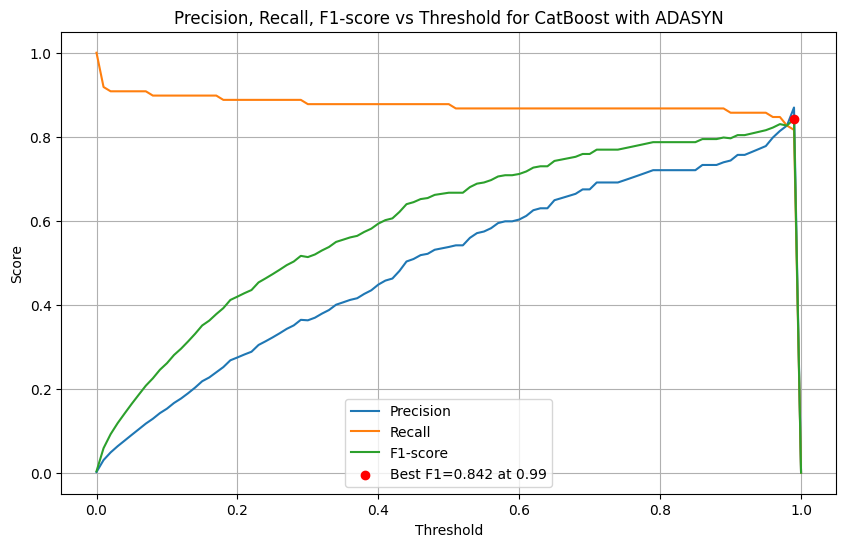

Best threshold for F1 score for CatBoost with ADASYN: 0.99
Results with ADASYN for CatBoost:
Metrics for test
Accuracy: 0.9995
Precision: 0.8696
Recall: 0.8163
F1: 0.8421

Metrics for train
Accuracy: 0.9986
Precision: 0.9856
Recall: 0.8771
F1: 0.9282

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.82      0.84        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



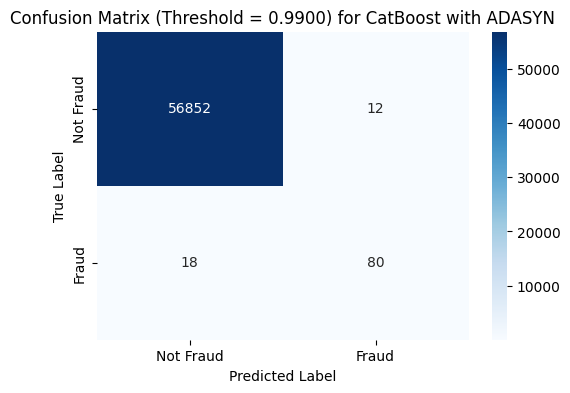

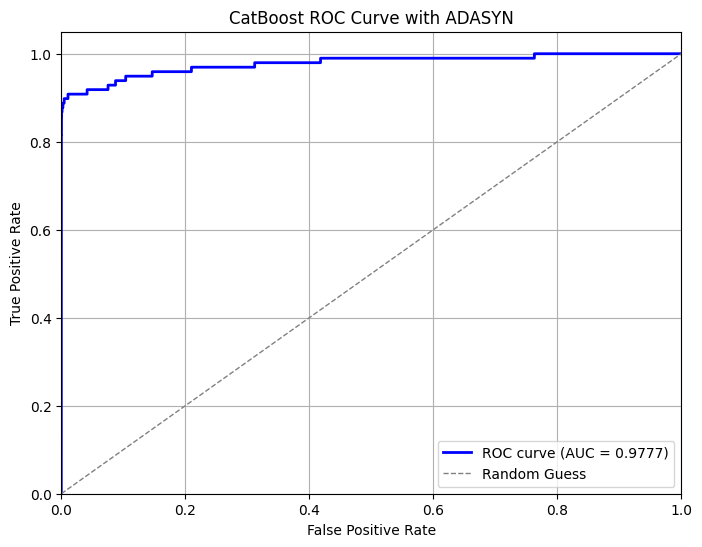

AUC: 0.9777


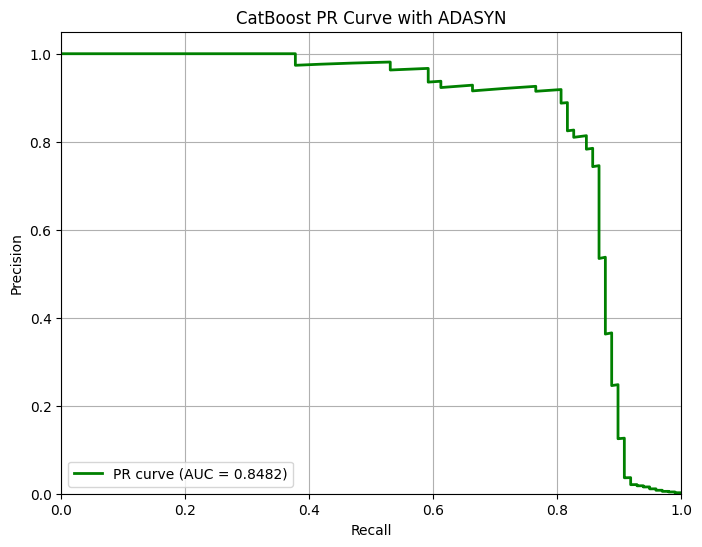

PR AUC: 0.8482


In [27]:
# Load the model with ADASYN
loaded_model_cb_adasyn = joblib.load('../models/cb_grid_search_adasyn.pkl')

# Predict probabilities for the test and training sets using the loaded CatBoost model with ADASYN
y_pred_cb_adasyn_proba = loaded_model_cb_adasyn.predict_proba(X_test)[:, 1]
y_pred_train_cb_adasyn_proba = loaded_model_cb_adasyn.predict_proba(X_res_adasyn)[:, 1]

# Find the best threshold for F1 score for CatBoost with ADASYN
threshold_cb_adasyn = find_best_f1_threshold(X_test, y_test, model=loaded_model_cb_adasyn, model_name="CatBoost with ADASYN")

# Calculate the treshold optimizing f1 score for CatBoost with ADASYN
print(f"Best threshold for F1 score for CatBoost with ADASYN: {threshold_cb_adasyn}")

# Calculate other metrics based on the threshold for CatBoost with ADASYN
print("Results with ADASYN for CatBoost:")
results_cb_adasyn = get_results(y_test, y_pred_cb_adasyn_proba, y_res_adasyn, y_pred_train_cb_adasyn_proba, threshold_cb_adasyn, model_name="CatBoost with ADASYN")

# Plot ROC and PR curves for CatBoost with ADASYN
roc_cb_adasyn = plot_roc_curve(loaded_model_cb_adasyn, X_test, y_test, title="CatBoost ROC Curve with ADASYN")
pr_auc_cb_adasyn = plot_pr_curve(loaded_model_cb_adasyn, X_test, y_test, title="CatBoost PR Curve with ADASYN")

# Creating a Summary

To compare model performance across different data preprocessing strategies (Original, SMOTE, ADASYN), we compile the results into a summary table. This table includes the following key evaluation metrics for each model:

- **Accuracy**: Overall correctness of the model’s predictions.
- **F1-score**: Harmonic mean of precision and recall; a crucial metric for imbalanced datasets.
- **Precision** and **Recall**: Indicate how well the model identifies positive cases (fraud).
- **ROC AUC** and **PR AUC**: Reflect the model’s ability to distinguish between classes, especially under class imbalance.
- **Training Time**: Total time taken to train each model, providing insight into computational efficiency.

This summary enables a well-rounded comparison, helping to:
- Identify the best-performing model,
- Evaluate the impact of oversampling (SMOTE and ADASYN),
- Balance predictive performance with computational cost.

In [ ]:
# Create a DataFrame to summarize the timing results
df_times = pd.DataFrame(timing_results)
display(df_times)

In [ ]:
# Create a DataFrame to store all results

# Merge timing results with evaluation metrics
# First, create the results DataFrame as before
results_df = pd.DataFrame({
    'Model': ['RandomForest', 'RandomForest SMOTE', 'RandomForest ADASYN',
              'XGBoost', 'XGBoost SMOTE', 'XGBoost ADASYN',
              'CatBoost', 'CatBoost SMOTE', 'CatBoost ADASYN'],
    'Accuracy': [
        results_rf['test']['accuracy'], results_rf_smote['test']['accuracy'], results_rf_adysyn['test']['accuracy'],
        results_xgb['test']['accuracy'], results_xgb_smote['test']['accuracy'], results_xgb_adasyn['test']['accuracy'],
        results_cb['test']['accuracy'], results_cb_smote['test']['accuracy'], results_cb_adasyn['test']['accuracy'],
    ], 
    'F1 score': [
        results_rf['test']['f1'], results_rf_smote['test']['f1'], results_rf_adysyn['test']['f1'],
        results_xgb['test']['f1'], results_xgb_smote['test']['f1'], results_xgb_adasyn['test']['f1'],
        results_cb['test']['f1'], results_cb_smote['test']['f1'], results_cb_adasyn['test']['f1']
    ],
    'Precision': [
        results_rf['test']['precision'], results_rf_smote['test']['precision'], results_rf_adysyn['test']['precision'],
        results_xgb['test']['precision'], results_xgb_smote['test']['precision'], results_xgb_adasyn['test']['precision'],
        results_cb['test']['precision'], results_cb_smote['test']['precision'], results_cb_adasyn['test']['precision']
    ],
    'Recall': [
        results_rf['test']['recall'], results_rf_smote['test']['recall'], results_rf_adysyn['test']['recall'],
        results_xgb['test']['recall'], results_xgb_smote['test']['recall'], results_xgb_adasyn['test']['recall'],
        results_cb['test']['recall'], results_cb_smote['test']['recall'], results_cb_adasyn['test']['recall']
    ],
    'ROC AUC': [
        roc_rf, roc_rf_smote, roc_rf_adasyn,
        roc_xgb, roc_xgb_smote, roc_xgb_adasyn,
        roc_cb, roc_cb_smote, roc_cb_adasyn
    ],
    'PR AUC': [
        pr_auc_rf, pr_auc_rf_smote, pr_auc_rf_adasyn,
        pr_auc_xgb, pr_auc_xgb_smote, pr_auc_xgb_adasyn,
        pr_auc_cb, pr_auc_cb_smote, pr_auc_cb_adasyn
    ]
})

# Merge with timing results
results_df = results_df.merge(df_times, left_on='Model', right_on='model', how='left').drop(columns=['model'])

display(results_df)

In [39]:
# Save the results DataFrame to a CSV file
results_df.to_csv('../results/tree_models_metrics.csv', index=False)